# Machine Learning: Support Vector Classifier

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from IPython.display import display, Latex, Markdown
import matplotlib.pyplot as plt

In [2]:
def cleanCases(gun_cases):
    # gun violence cases dataset cleaned
    cases = pd.read_csv(gun_cases)
    cases = cases.loc[:, ['date', 'state', 'n_killed', 'n_injured']]

    cases['date'] = pd.to_datetime(cases['date'])
    cases['year'] = cases['date'].dt.year
    cases['harmed'] = cases['n_killed'] + cases['n_injured']
    cases = cases.drop(columns=['date', 'n_killed', 'n_injured'])
    cases = cases[(cases['year'] > 2013) & (cases['year'] < 2018)]
    cases = cases.groupby(['state', 'year']).agg('sum')
    cases = cases.reset_index()
    return cases

def cleanLaws(gun_laws):
    # gun laws dataset cleaned
    laws = pd.read_csv(gun_laws)
    laws = laws[(laws['year'] > 2014) & (laws['year'] < 2018)]
    return laws

def cleanPopulation(population):
    # state population dataset cleaned
    #importing state population counts from 2010 - 2019
    state_populations = pd.read_csv(population)

    #cleaning state population data
    state_populations = state_populations.drop(columns=['2010', '2011', '2012', '2013', '2018', '2019'])
    return state_populations

def combineDatasets(gun_cases, gun_laws, population):
    cases = cleanCases(gun_cases)
    laws = cleanLaws(gun_laws)
    state_population = cleanPopulation(population)
    
    # adding population counts to cases dataset by matching year and state
    for i, row in cases.iterrows():
        cases.at[i, ('population')] = float(state_population[state_population.state == row['state']][str(row['year'])])

    #compute the proportion of harmed individuals due to a gun incident out of the state population 
    cases['proportion_harmed'] = cases['harmed']/cases['population']
    cases.drop(columns=['harmed', 'population'], inplace=True)
    # Check if gun cases were reduced based on previous year values (only valid for 2015-2017)
    harmed = cases['proportion_harmed'].tolist()
    decrease = list()

    # False = (Decrease = 0), True = (Decrease = 1)
    for i in range(0, len(harmed), 4):
        decrease.append(False)                           # Year 2014; Temporary Place-Holder
        decrease.append(harmed[i] > harmed[i+1])         # Year 2015
        decrease.append(harmed[i+1] > harmed[i+2])       # Year 2016
        decrease.append(harmed[i+2] > harmed[i+3])       # Year 2017

    cases['decrease_in_gun_violence'] = pd.Series(decrease)
    cases = cases.drop(labels=range(0, len(decrease), 4), axis=0)
    cases = cases[(cases['state'] != 'District of Columbia')]
    
    # Combined dataset
    data = cases.merge(laws, on=['state', 'year'], how='outer')
    return data

In [3]:
gun_cases = 'gun-violence-data_01-2013_03-2018.csv'
gun_laws = 'statefirearmlaws.csv'
population = 'us_states_census.csv'
data = combineDatasets(gun_cases, gun_laws, population)

In [4]:
data.head(5)

,state,year,proportion_harmed,decrease_in_gun_violence,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,2015,0.000195,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
1,Alabama,2016,0.000257,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Alabama,2017,0.000287,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
3,Alaska,2015,0.000209,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Alaska,2016,0.000258,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


# Oversampling Dataset

To balance out our decrease_in_gun_violence classes, we oversample from the decrease_in_gun_violence=1 class. 

Oversampling= replicating some points from the minority class in order to increase its cardinality [handling imbalanced datasets](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

In [5]:
oversampled_rows = data[data.decrease_in_gun_violence == True].copy(deep=True)
balanced_data = pd.concat([data, oversampled_rows], ignore_index=True)

print(f'Shape: {balanced_data.shape}')
print(f'Number of examples in our balanced dataset where decrease_in_gun_violence=0: {len(balanced_data[balanced_data.decrease_in_gun_violence == False])}')
print(f'Number of examples in our balanced dataset where decrease_in_gun_violence=1: {len(balanced_data[balanced_data.decrease_in_gun_violence == True])}')

Shape: (199, 139)
Number of examples in our balanced dataset where decrease_in_gun_violence=0: 101
Number of examples in our balanced dataset where decrease_in_gun_violence=1: 98


# Create the features and labels for classification.

In [6]:
def create_features_labels(dataset): 
    X = dataset.drop(columns = ['decrease_in_gun_violence', 'state', 'year']) #keep all law reform info as features, as well as the proportion of individuals harmed
    y = dataset['decrease_in_gun_violence']   # Labels are if the number of cases reduced
    y = y.replace({True: 1, False: 0})
    return X, y

# X, y = create_features_labels(data)
X, y = create_features_labels(balanced_data)

In [7]:
#checking proportion of classes w.r.t 'decrease'
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=0: {len(y[y == 0])}')
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=1: {len(y[y == 1])}')

Number of examples in our entire dataset where decrease_in_gun_violence=0: 101
Number of examples in our entire dataset where decrease_in_gun_violence=1: 98


# Baseline Classifier

Create a baseline classifier `MajorityLabelClassifier` to test our classifier against. This will always predict the class equal to the mode of the labels.

In [8]:
class MajorityLabelClassifier():
    # Initialize parameter for the classifier
    def __init__(self):
        self.mode = 0
    
    # Fit the data by taking training data X and their labels y and storing the learned parameter
    def fit(self, X, y):
        modes = dict()           # Stores all the modes of the training data
        y = y.tolist()
        for i in range(len(X)):
            if y[i] in modes.keys():
                modes[y[i]] += 1
            else:
                modes[y[i]] = 1
                
        # Find the most frequent mode and store it
        total = 0
        for key in modes:
            if modes[key] > total:
                total = modes[key]
                self.mode = key
    
    # Predict the label for each instance X as the learned parameter
    def predict(self, X):
        labels = list()
        for i in X:
            labels.append(self.mode)
        return labels
    
    # Calculate the accuracy of our classifier using the true and predicted labels
    def evaluate_accuracy(self, y, y_predict):
        accurate_pred = 0
        total = len(y_predict)
        true_labels = y.tolist()
        
        for i in range(total):
            if true_labels[i] == y_predict[i]:
                accurate_pred += 1
        return accurate_pred/total

In [9]:
baseline = MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.6838235294117647


# Support Vector Classifier

Evaluate the `SupportVectorClassifier()` by training, fitting, and predicting on the data.

`we should use cross validation to fine tune some of our parameters and try to increase our accuracy up to 80%`

In [14]:
def learn_classifier(X_train, y_train, kernel):
    """ learns a classifier from the input features and labels using the kernel function supplied
    Inputs:
        X_train: scipy.sparse.csr.csr_matrix: sparse matrix of features, output of create_features()
        y_train: numpy.ndarray(int): dense binary vector of class labels, output of create_labels()
        kernel: str: kernel function to be used with classifier. [linear|poly|rbf|sigmoid]
    Outputs:
        sklearn.svm.SVC: classifier learnt from data
    """
    
    # svc =  sklearn.svm.SVC(kernel = kernel)
    svc =  svm.SVC(kernel = kernel)
    return svc.fit(X_train, y_train)

In [15]:
#fit svc model + predict on test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test
clf_model = learn_classifier(X_train, y_train, 'linear')  
y_predict = clf_model.predict(X_test)

Train Accuracy: 0.6633165829145728
Test Accuracy: 0.4
precision: [0.47058824 0.34782609]
recall   : [0.34782609 0.47058824]
f1 score : [0.4 0.4]


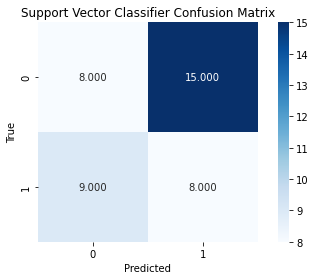

In [16]:
#evaluation metrics
train_accuracy = clf_model.score(X,y)  #this gives training accuracy
test_accuracy = accuracy_score(y_test, y_predict) #this gives testing accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

cm = confusion_matrix(y_test, y_predict) #confusion matrix
precision, recall, f1, support =  precision_recall_fscore_support(y_test, y_predict) #precision, recall, f1 score, and support for each class (decrease_in_gun_violence=0 and decrease_in_gun_violence=1)

print(f'precision: {precision}')
print(f'recall   : {recall}')
print(f'f1 score : {f1}')

#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues);
plt.ylabel('True');
plt.xlabel('Predicted');
plt.title('Support Vector Classifier Confusion Matrix');
plt.tight_layout();

Results from linear SVC aren't very good. While our predictions for both classes are well-balanced, we only obtained a test accuracy of 40%, and low precision, recall, and f1 scores. In the next steps, we'll do some cross-validation to tune the parameters of our SVC model and hopefully increase the accuracy.

# Cross-Validation for SVC Parameter Tuning

In [27]:
def evaluate_classifier(classifier, X_validation, y_validation):
    """ evaluates a classifier based on a supplied validation data
    Inputs:
        classifier: sklearn.svm.classes.SVC: classifer to evaluate
        X_validation: scipy.sparse.csr.csr_matrix: sparse matrix of features
        y_validation: numpy.ndarray(int): dense binary vector of class labels
    Outputs:
        double: accuracy of classifier on the validation data
    """
    y_pred = classifier.predict(X_validation)
    return sklearn.metrics.accuracy_score(y_validation, y_pred)

def best_model_selection(kf, X, y):
    """
    Select the kernel giving best results using k-fold cross-validation.
    Other parameters should be left default.
    Input:
    kf (sklearn.model_selection.KFold): kf object defined above
    X (scipy.sparse.csr.csr_matrix): training data
    y (array(int)): training labels
    Return:
    best_kernel (string)
    """
    kernel_accuracies = dict()
    for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
        fold_accuracies = []
        for train_index, test_index in kf.split(X):
            
            # Use the documentation of KFold cross-validation to split
            # training data and test data from create_features() and create_labels()
            X_train, y_train = X.loc[train_index], y.loc[train_index]
            X_test,  y_test  = X.loc[test_index] , y.loc[test_index]
            
            # call learn_classifer() using training split of kth fold
            classifier = learn_classifier(X_train, y_train, kernel)
            
            # evaluate on the test split of kth fold
            fold_accuracy = evaluate_classifier(classifier, X_test, y_test)
            fold_accuracies.append(fold_accuracy)

        # record avg accuracies and determine best model (kernel)
        avg_fold_accuracy = np.mean(fold_accuracies)
        kernel_accuracies[kernel] = avg_fold_accuracy

    # return best kernel as string
    print(kernel_accuracies)
    best_kernel = max(kernel_accuracies, key = kernel_accuracies.get)
    return best_kernel

In [28]:
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True) #5-fold cross validation
kf

KFold(n_splits=4, random_state=1, shuffle=True)

In [41]:
#reset indices of X_train and y_train to avoid indexing errors during CV
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

#use CV to find the best_kernel for our SVC model
best_kernel = best_model_selection(kf, X_train, y_train)
print(f'Best kernel selected via cross-validation: {best_kernel}')

#train and predict classifier
classifier = learn_classifier(X_train, y_train, kernel=best_kernel)
y_predict = clf_model.predict(X_test)

classifier

{'linear': 0.5407051282051282, 'rbf': 0.452724358974359, 'poly': 0.49022435897435895, 'sigmoid': 0.515224358974359}
Best kernel selected via cross-validation: linear


SVC(kernel='linear')

Train Accuracy: 0.6633165829145728
Test Accuracy: 0.4
precision: [0.47058824 0.34782609]
recall   : [0.34782609 0.47058824]
f1 score : [0.4 0.4]


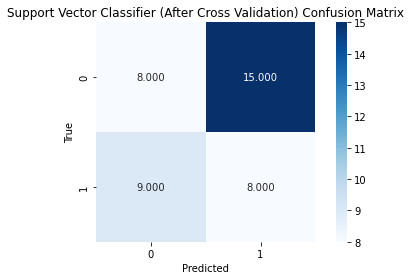

In [42]:
#evaluation metrics
train_accuracy = classifier.score(X,y)  #this gives training accuracy
test_accuracy = accuracy_score(y_test, y_predict) #this gives testing accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

cm = confusion_matrix(y_test, y_predict) #confusion matrix
precision, recall, f1, support =  precision_recall_fscore_support(y_test, y_predict) #precision, recall, f1 score, and support for each class (decrease_in_gun_violence=0 and decrease_in_gun_violence=1)

print(f'precision: {precision}')
print(f'recall   : {recall}')
print(f'f1 score : {f1}')

#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues);
plt.ylabel('True');
plt.xlabel('Predicted');
plt.title('Support Vector Classifier (After Cross Validation) Confusion Matrix');
plt.tight_layout();

Cross Validation selects the best kernel to be 'linear' , which gives the same performance results as without using cross validation to select the best kernel. No improvement in model performance after using cross validation to select best kernel for SVC model.